In [1]:
import os
import sys
sys.path.append(os.path.abspath('../src'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('../data/copolymer/copolymer_data_all.csv')

In [4]:
X1 = np.array(df.loc[:,'x1']).astype(np.float64)
X2 = np.array(df.loc[:,'x2']).astype(np.float64)
X = np.vstack((X1, X2)).T

# X = torch.from_numpy(X).to(torch.float64)

Y = np.array(df.loc[:,'rg_mean'])
# Y = torch.from_numpy(Y).to(torch.float64).unsqueeze(-1)

# noise = np.array(np.square(df.loc[:,'rg_std']))
# noise = torch.from_numpy(noise).to(torch.float64).unsqueeze(-1)

In [5]:
torch.manual_seed(42)
n = X.shape[0]
perm = torch.randperm(n)
train_idx = perm[:25]
test_idx = perm[25:]

In [6]:
train_X = X[train_idx]
train_Y = Y[train_idx]
# train_noise = noise[train_idx]

test_X = X[test_idx]
test_Y = Y[test_idx]
# test_noise = noise[test_idx]

In [7]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('model', RandomForestRegressor())
])

In [8]:
param_grid = {
    'model__n_estimators': [50, 100, 200, 500],
    'model__max_depth': [None, 10, 20, 50],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt'],
    'model__bootstrap': [True, False],                  
}

In [9]:
model = RandomizedSearchCV(
    pipe, 
    param_grid,
    n_iter=100,
    refit=True, 
    verbose=0, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=RepeatedKFold(n_splits=5, n_repeats=5)
)

In [10]:
model.fit(train_X, train_Y)

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('scaler',
                                              MinMaxScaler(feature_range=(-1,
                                                                          1))),
                                             ('model',
                                              RandomForestRegressor())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [None, 10, 20, 50],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [50, 100, 200,
                                                                500]},
                   scoring='neg_mean_squared_error')

In [11]:
best_pipe = model.best_estimator_

In [12]:
print(model.best_params_)

{'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': None, 'model__bootstrap': True}


In [13]:
test_X_scaled = best_pipe.named_steps['scaler'].transform(test_X)

rf_model = best_pipe.named_steps['model']

pred_all = np.stack([tree.predict(test_X_scaled) for tree in rf_model.estimators_], axis=0)

pred_mean = np.mean(pred_all, axis=0)
pred_std = np.std(pred_all, axis=0)
pred_var = pred_std**2

In [14]:
def plot_ypred_vs_ytrue(ypred, ytrue):
    plt.figure(figsize=(8, 8))
    plt.scatter(ytrue, ypred, alpha=0.6)
    plt.xlabel('True', fontsize=20)
    plt.ylabel('Predicted', fontsize=20)
    plt.tick_params(axis='both', labelsize=16)
    plt.plot([ytrue.min(), ytrue.max()], [ytrue.min(), ytrue.max()], 'r--')
    plt.show()

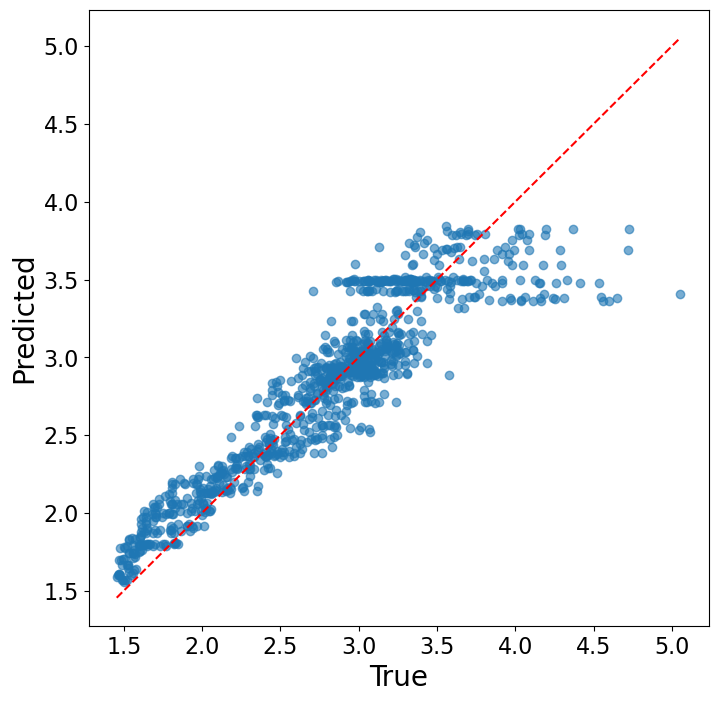

In [15]:
plot_ypred_vs_ytrue(pred_mean, test_Y)

In [16]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(test_Y, pred_mean)
rmse = np.sqrt(mean_squared_error(test_Y, pred_mean))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.8533
RMSE: 0.2578


In [17]:
from UQtools import order_sig_and_errors, get_slope_metric, spearman_rank_corr, expected_rho, calibration_curve, calibration_area, plot_calibration_curve, plot_Z_scores, NLL

In [18]:
data = np.column_stack((test_Y, pred_mean, np.sqrt(pred_var)))
df_uq = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])

df = pd.DataFrame(data, columns=['test_y', 'pred_y', 'uq'])
df['error'] = df['pred_y'] - df['test_y']

In [19]:
df

,test_y,pred_y,uq,error
0,2.448029,2.837805,0.086537,0.389776
1,2.831312,2.863588,0.173387,0.032276
2,3.158686,2.928290,0.139769,-0.230396
3,3.328809,3.484049,0.291340,0.155240
4,2.945838,3.427161,0.247151,0.481323
...,...,...,...,...
990,4.020607,3.825179,0.147913,-0.195429
991,2.744313,2.848384,0.095883,0.104071
992,2.536614,2.566116,0.625718,0.029502
993,2.938480,2.996738,0.164125,0.058258


rho_rank = 0.26
rho_rank_sim = 0.53 +/- 0.02
miscalibration area = 0.06
NLL = 0.18
NLL_sim = 0.11 +/- 0.02
R squared: 0.6772865887917243
intercept: 0.09147670497852273
slope: 0.4592503206414597


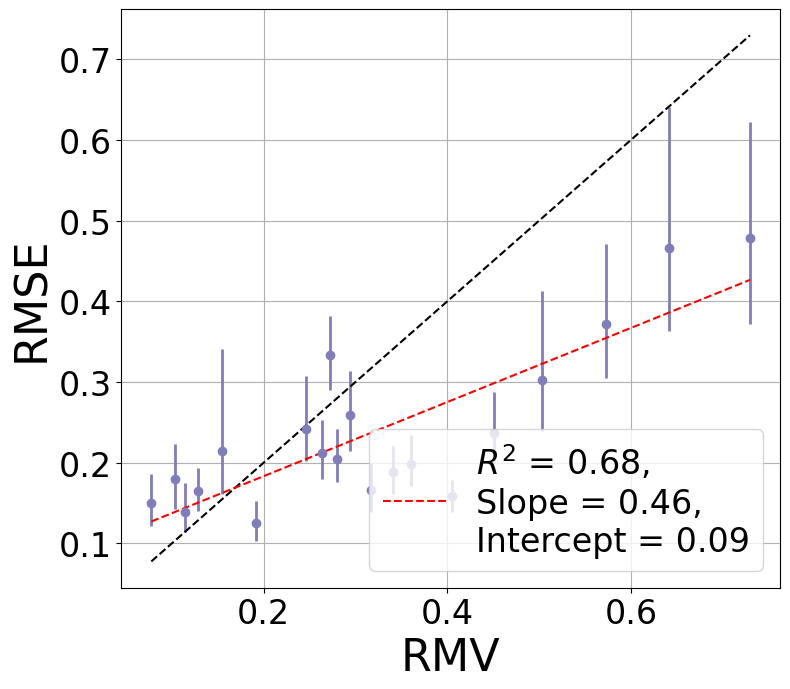

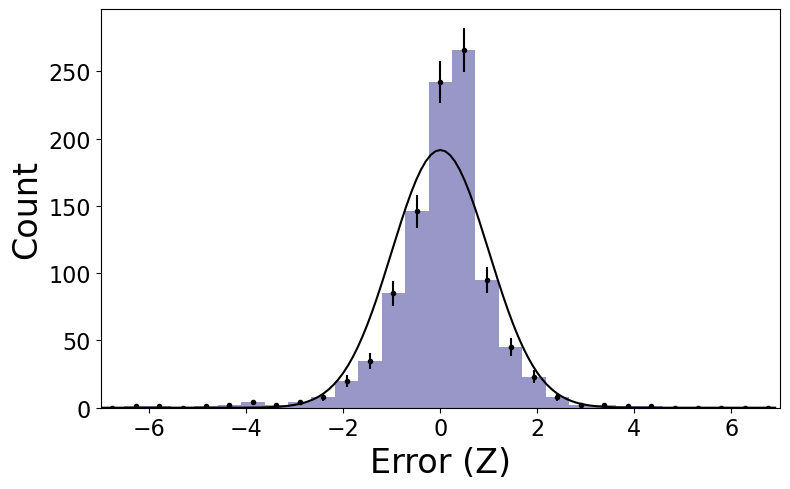

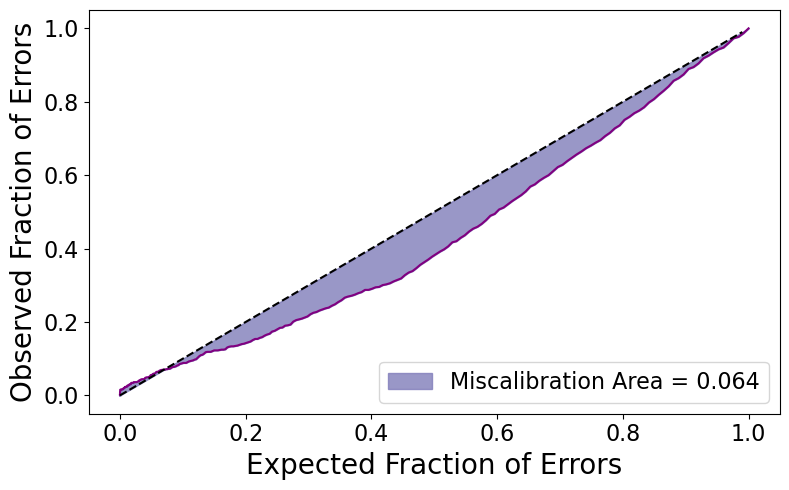

In [20]:
#Order uncertainties and errors according to uncertainties
ordered_df = order_sig_and_errors(df.uq, df.error)

#Calculate rho_rank and rho_rank_sim
rho_rank, _ = spearman_rank_corr(np.abs(df.error), df.uq)
print(f'rho_rank = {rho_rank:.2f}')
exp_rhos_temp = []
for i in range(1000):
    exp_rho, _ = expected_rho(df.uq)
    exp_rhos_temp.append(exp_rho)
rho_rank_sim = np.mean(exp_rhos_temp)
rho_rank_sim_std = np.std(exp_rhos_temp)
print(f'rho_rank_sim = {rho_rank_sim:.2f} +/- {rho_rank_sim_std:.2f}')

#Calculate the miscalibration area
gaus_pred, errors_observed = calibration_curve(ordered_df.abs_z)
mis_cal = calibration_area(errors_observed, gaus_pred)
print(f'miscalibration area = {mis_cal:.2f}')

#Calculate NLL and simulated NLL
_NLL = NLL(df.uq, df.error)
print(f'NLL = {_NLL:.2f}')
exp_NLL = []
for i in range(1000):
    sim_errors = []
    for sigma in df.uq:
        sim_error = np.random.normal(0, sigma)
        sim_errors.append(sim_error)
    NLL_sim = NLL(df.uq, sim_errors)
    exp_NLL.append(NLL_sim)
NLL_sim = np.mean(exp_NLL)
NLL_sim_std = np.std(exp_NLL)
print(f'NLL_sim = {NLL_sim:.2f} +/- {NLL_sim_std:.2f}')

#Generate error-based calibration plot
fig, slope, R_sq, intercept = get_slope_metric(ordered_df.uq, ordered_df.errors, Nbins=20)

#Generate Z-score plot and calibration curve
fig2, ax2 = plot_Z_scores(ordered_df.errors, ordered_df.uq)
fig3 = plot_calibration_curve(gaus_pred, errors_observed, mis_cal)